### To do - August 28th
* add time-related features
* check tthat all the features are well encoded (only numerical values)
* Save final df as csv files in output/pre-processing

### Data Frame Merging Roadmap
#### 1. PD Feat
* DIAGFEAT
* EPWORTH
* LNSPD
* REMSLEEP
* SCOPAAUT
* COGATG
* HVLT
* MOCA
* GDSSHORT
* SDM
* STAI
* BENTONOD
* QUIPCS

#### 2. Gen Medical info
* GENPHYEX
* PENEURO
* PENEURO2
* VITAL
#### 3. PD Progression measurements (motors)
* NUPDRS1
* NUPDRS2P
* NUPDR3
* NUPDRS4
* (PASELT)
* MODSEADL

#### 4. Medications data
* PDMEDUSE
* (CURRCOND)
* SURGPD

#### 5. Non TS Features
* SCREEN - Gen Med info
* PDFEAT - PD feat
* MHXGEN - Gen Med info
* Biospecimen_analysis: ? 
* LUMBAR - Gen Med info
* PRIMDX - PD Feat
* PRODIAG - PD Feat
* to add: time since the last hospital visit - PD Feat

#### 6. Targets (from num3)
    *MSEADLG
    *NHY
    
#### Around 400 features!!

In [1]:
#imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import urllib.parse
from glob import glob
import os
import ntpath 
import zipfile

PPMI_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/'

In [2]:
def reading_csv_files(folder_path):
    # saving all the csv files in a dataframe
    import os
    import glob
    # glob.glob('*.csv') #find all the csv files in a pathname. 
    os.chdir(folder_path)
    csv_files = [i for i in glob.glob('*.csv')]

    # Reading each csv file and storing them in a dictionnary containing the file name and the dataframe
    dict_files={}
    files_names=[]
    for files in csv_files:
        df=pd.read_csv(files,engine='python')
        basepath, filename=ntpath.split(files)
        files_names.append(filename)
        dict_files[filename]=df

    # Calculating the # of rows and features for each dataframe and storing them in a list of tuples
    shape_df=[]
    for i in range(0,len(dict_files.keys())):
        nrows, ncols=(len(dict_files[files_names[i]]),len(dict_files[files_names[i]].columns))
        shape_df.append((nrows,ncols))

    return (shape_df,files_names,dict_files)

In [3]:
def number_of_patients(df):
    '''return the number of patients in each csv files'''
    if 'PATNO' in df.columns:
        patients=len(list(set(df['PATNO'])))
    else: 
        patients=0
    return patients

In [4]:
def number_of_events(df): 
    '''return the number of events covered by each csv file'''
    if 'EVENT_ID' in df.columns:
        events=len(list(set(df['EVENT_ID'])))
    else: 
        events=0
    return events

In [5]:
def features_selection(list_df_SEL):
    '''do features selection for each df,sel in list_df_sel (dictionnary)'''
    return 

In [6]:
def patients_selection(df, threshold=6):
    '''return a dataframe containing only the patients with number of visits > threshold'''
    if 'PATNO' in df.columns: 
        visits_number_by_pat=df.groupby('PATNO').size().sort_values(ascending=False)
        mask_sel=visits_number_by_pat>=threshold
        patients_sel=list(mask_sel[mask_sel.values==True].index)
        df=df.loc[df['PATNO'].isin(patients_sel),:]
        df=df.sort_values('PATNO')
        return (patients_sel, df)
    else:
        return 0

In [7]:
def PD_patients_selection(df):
    folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/1-Subject-Characteristics/'
    files_names=reading_csv_files(folder_path)[1]
    dict_files=reading_csv_files(folder_path)[2]

    ### Patient_Status - actually useful for selecting only the PD patients in each table
    PRODROMA=dict_files[files_names[0]]
    PD_cat=['PD','REGPD','GENPD']
    PD_patients=list(PRODROMA.loc[PRODROMA['RECRUITMENT_CAT'].isin(PD_cat),'PATNO'])
    sub_df=df.loc[df['PATNO'].isin(PD_patients),:]
    return (PD_patients,sub_df)

In [8]:
def table_analysis(list_df,df_names,threshold=6): 
    '''return a dataframe with: 
    -as rows: list of df
    -as columns: 
        - total number of observations=rows
        - total number of features=columns after features_selection - features_selection function 
        - number of events
        - number of PD patients by using PRODROMA info - number_of_patients function
        - number of patients with # of visits > threshold - number_of_patients function
        - shape of final df after selections of rows and columns
        -number of NaN values in the final df
        NB: takes as input the df with features selection. 
    '''   
    # initialisation df
    col=['observations_tot','features','events_num','patients_num','patients_sel','len_df_sel','NaN_values']
    df_df=pd.DataFrame(columns=col,index=df_names)

    # remplissage of dataframe for each row
    for i,df in enumerate(list_df): 
        df_df.iloc[i,:]['observations_tot']=len(df)
        df_df.iloc[i,:]['features']=len(df.columns)
        df_df.iloc[i,:]['events_num']=number_of_events(df)
        df_df.iloc[i,:]['patients_num']=number_of_patients(df)
        
        if not patients_selection(df)==0:
            df=patients_selection(df,threshold=threshold)[1]
            df=PD_patients_selection(df)[1]          
            df_df.iloc[i,:]['patients_sel']=len(set(df['PATNO']))
        else: 
            if 'PATNO' in df.columns:
                df=PD_patients_selection(df)[1]
                df_df.iloc[i,:]['patients_sel']=len(set(df['PATNO']))
            else:
                df_df.iloc[i,:]['patients_sel']=0            
        df_df.iloc[i,:]['len_df_sel']=len(df)
        df_df.iloc[i,:]['NaN_values']=(df.isnull().sum().sum())/(df_df.iloc[i,:]['len_df_sel']*df_df.iloc[i,:]['features'])
        
    return df_df

In [9]:
def INFODT_date(df):
    if 'INFODT' in df.columns: 
        df['INFODT_date']=df['INFODT'].apply(lambda x: datetime.strptime(x,'%m/%Y'))
    return df

In [10]:
def merge(df_left,df_right,on=['PATNO','EVENT_ID','INFODT'],how='inner'): 
    df=pd.merge(df_left,df_right,on=on,how=how)
    return df

In [181]:
def merge_multiple_df(list_df,on=['PATNO','EVENT_ID','INFODT'],how='inner'): 
    ## Dropping useless columns: 
    for df in list_df: 
        if all(a in ['REC_ID','PAG_NAME'] for a in list(df.columns)):
            df.drop(columns=['REC_ID','PAG_NAME'],inplace=True)
        elif 'REC_ID' in list(df.columns):
            df.drop(columns=['REC_ID'],inplace=True)
        elif 'PAG_NAME' in list(df.columns):
            df.drop(columns=['PAG_NAME'],inplace=True)

    ## Merging the PD features
    merged_df=merge(list_df[0],list_df[1],on=on,how=how)
    print((sum(list_df[0].duplicated(subset=on)),sum(list_df[1].duplicated(subset=on))))
    print((len(merged_df)),len(set(merged_df['PATNO'])))
    for df in list_df[2:]: 
        merged_df=merge(merged_df,df,on=on,how=how)
        print((len(merged_df)),len(set(merged_df['PATNO'])))
        print(sum(df.duplicated(subset=on)))
    return merged_df

### Loading and selecting features in tables

In [340]:
## 5-Medical History
### PDFEAT is important - keep it.

folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/5-Medical-History/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### 'Diagnostic_Features.csv': useful: Feat-PD - 1670 patients.
DIAGFEAT=dict_files[files_names[1]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID','INFODT',
       'DFSTROKE', 'DFRSKFCT', 'DFPRESNT', 'DFRPROG', 'DFSTATIC', 'DFHEMPRK',
       'DFAGESX', 'DFOTHCRS', 'DFRTREMP', 'DFRTREMA', 'DFPATREM',
       'DFOTHTRM', 'DFRIGIDP', 'DFRIGIDA', 'DFAXRIG', 'DFUNIRIG',
       'DFTONE', 'DFOTHRIG', 'DFBRADYP', 'DFBRADYA', 'DFAKINES',
       'DFBRPLUS', 'DFOTHABR', 'DFPGDIST', 'DFGAIT', 'DFFREEZ',
       'DFFALLS', 'DFOTHPG', 'DFPSYCH', 'DFCOGNIT', 'DFDYSTON',
       'DFCHOREA', 'DFMYOCLO', 'DFOTHHYP', 'DFHEMTRO', 'DFPSHYPO',
       'DFSEXDYS', 'DFURDYS', 'DFBWLDYS', 'DFOCULO', 'DFEYELID', 'DFNEURAB',
       'DFDOPRSP', 'DFRAPSPE', 'DFBULBAR','DFATYP']
DIAGFEAT_sel=DIAGFEAT[SEL]


### General_Physical_Exam: useful: Feat-Gen - 2047 patients
GENPHYEX=dict_files[files_names[5]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID','INFODT',
       'PESEQ', 'ABNORM']
GENPHYEX_sel=GENPHYEX[SEL]
GENPHYEX_agg=GENPHYEX_sel.groupby(['PATNO','EVENT_ID','INFODT']).agg({'PESEQ': lambda x:list(x),
                                                         'ABNORM':lambda x: round(np.mean(x),0)})
GENPHYEX_agg.unstack(level=[0,1,2]).to_frame().rename(columns={0:'PESEQ'})
GENPHYEX_agg.reset_index(level=[0,1,2],inplace=True)
PEseq_cat=list(range(1,14))
for i in PEseq_cat:
    GENPHYEX_agg['PESEQ_{}'.format(i)]=GENPHYEX_agg.PESEQ.apply(lambda x: x.count(i))
GENPHYEX_agg.drop_duplicates(subset='PATNO',inplace=True)
GENPHYEX_agg.drop(columns='PESEQ',inplace=True)

### 'General_Neurological_Exam.csv': useful: Feat-Gen - 2048 patients
PENEURO=dict_files[files_names[7]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID','INFODT',
       'MSRARSP','MSLARSP','MSRLRSP',
       'MSLLRSP', 'COFNRRSP', 'COFNLRSP',
       'COHSRRSP', 'COHSLRSP', 'SENRARSP',
       'SENLARSP', 'SENRLRSP', 'SENLLRSP',
       'RFLRARSP', 'RFLLARSP', 'RFLRLRSP',
       'RFLLLRSP', 'PLRRRSP', 'PLRLRSP']
PENEURO_sel=PENEURO[SEL]

### 'Neurological_Exam_-_Cranial_Nerves.csv': useful: Feat-PD - 2049 patients
PENEURO2=dict_files[files_names[13]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID','INFODT',
       'CN1RSP','CN2RSP', 'CN346RSP','CN5RSP',
     'CN7RSP', 'CN8RSP', 'CN910RSP',
       'CN11RSP', 'CN12RSP']
PENEURO2_sel=PENEURO2[SEL]


### 'Vital_Signs.csv': useful: Feat-Gen
### 2047 patients
VITAL=dict_files[files_names[15]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID','INFODT', 'SYSSUP', 'DIASUP', 'HRSUP',
       'SYSSTND', 'DIASTND', 'HRSTND']
VITAL_sel=VITAL[SEL]

## 6-Motor-Assessments - all of them can be useful. 
#* UPDRS1 assesses non-motor experiences of daily-living 
#* UPDRS2P assesses motor experiences of daily living
#* UPDRS3 assesses motor signs of PD. Includes Hoehn & Yahr Stage. 
#* UPDRS4 assesses motor complications, dyskinesias, & moto fluctuations using historical & objective information.

folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/6-Motor-Assessments/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### 'MDS_UPDRS_Part_I__Patient_Questionnaire.csv' - 2011 patients
NUPDR1SP=dict_files[files_names[0]]

### 'MDS_UPDRS_Part_I.csv' - 2010 patients - 
NUPDRS1=dict_files[files_names[2]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID','INFODT',
       'NP1COG', 'NP1HALL', 'NP1DPRS', 'NP1ANXS', 'NP1APAT',
       'NP1DDS']
NUPDRS1_sel=NUPDRS1[SEL]

### 'MDS_UPDRS_Part_II__Patient_Questionnaire.csv' - 2011 patients
NUPDRS2P=dict_files[files_names[11]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID','INFODT',
       'NP2SPCH', 'NP2SALV', 'NP2SWAL', 'NP2EAT', 'NP2DRES',
       'NP2HYGN', 'NP2HWRT', 'NP2HOBB', 'NP2TURN', 'NP2TRMR', 'NP2RISE',
       'NP2WALK', 'NP2FREZ']
NUPDRS2P_sel=NUPDRS2P[SEL]

### 'MDS_UPDRS_Part_III.csv' - 2010 patients
NUPDRS3=dict_files[files_names[7]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID','INFODT','NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU',
       'NP3RIGLU', 'PN3RIGRL', 'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR',
       'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR',
       'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR',
       'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU',
       'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'DYSKPRES','NHY','ON_OFF_DOSE',
       'PD_MED_USE']
NUPDRS3_sel=NUPDRS3[SEL]

target_NHY=NUPDRS3[['PATNO','EVENT_ID','INFODT','NHY']]


### 'MDS_UPDRS_Part_IV.csv' - 860 patients
NUPDRS4=dict_files[files_names[5]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID','INFODT',
       'NP4WDYSK', 'NP4DYSKI', 'NP4OFF', 'NP4FLCTI', 'NP4FLCTX', 'NP4DYSTN']
NUPDRS4_sel=NUPDRS4[SEL]

### 'PASE_-_Household_Activity.csv' - 1248 patients
PASE=dict_files[files_names[3]]

### 'PASE_-_Leisure_Time_Activity.csv' - 1248 patients
PASELT=dict_files[files_names[10]]

### 'Modified_Schwab_+_England_ADL.csv' - 1837 patients
MODSEADL=dict_files[files_names[6]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID','INFODT',
       'MSEADLG']
MODSEADL=MODSEADL[SEL]
target_MSEADLG=MODSEADL[['PATNO','EVENT_ID','INFODT','MSEADLG']]

## 7-Non-motor-assessments - all of them can be useful but we might need to choose. 
### Do a correlation analysis and ask doctors which ones are the more relevant. 

folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/7-Non-motor-assessments/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### 'University_of_Pennsylvania_Smell_ID_Test.csv' - 1799 patients - OLFACTION
UPSIT=dict_files[files_names[0]]

### 'Epworth_Sleepiness_Scale.csv - 1343 patients - SLEEP. 
EPWORTH=dict_files[files_names[2]]

### 'Letter_-_Number_Sequencing__PD_.csv' - 1341 patients. - MEMORY. 
LNSPD=dict_files[files_names[3]]

### 'Olfactory_UPSIT.csv' - 4468 patients - OLFACTION. 
#### NB: only take the 2 last columns as features (TOTAL_CORRECT, UPSIIT_PRCNTGE)
OLFACT=dict_files[files_names[4]]
col_old=list(OLFACT.columns)
col_new=['PAT_NO', 'PROTOCOL_ID', 'INFODT', 'SCENT_10_RESPONSE',
       'SCENT_09_RESPONSE', 'SCENT_08_RESPONSE', 'SCENT_07_RESPONSE',
       'SCENT_06_RESPONSE', 'SCENT_05_RESPONSE', 'SCENT_04_RESPONSE',
       'SCENT_03_RESPONSE', 'SCENT_02_RESPONSE', 'SCENT_01_RESPONSE',
       'SCENT_20_RESPONSE', 'SCENT_19_RESPONSE', 'SCENT_18_RESPONSE',
       'SCENT_17_RESPONSE', 'SCENT_16_RESPONSE', 'SCENT_15_RESPONSE',
       'SCENT_14_RESPONSE', 'SCENT_13_RESPONSE', 'SCENT_12_RESPONSE',
       'SCENT_11_RESPONSE', 'SCENT_30_RESPONSE', 'SCENT_29_RESPONSE',
       'SCENT_28_RESPONSE', 'SCENT_27_RESPONSE', 'SCENT_26_RESPONSE',
       'SCENT_25_RESPONSE', 'SCENT_24_RESPONSE', 'SCENT_23_RESPONSE',
       'SCENT_22_RESPONSE', 'SCENT_21_RESPONSE', 'SCENT_40_RESPONSE',
       'SCENT_39_RESPONSE', 'SCENT_38_RESPONSE', 'SCENT_37_RESPONSE',
       'SCENT_36_RESPONSE', 'SCENT_35_RESPONSE', 'SCENT_34_RESPONSE',
       'SCENT_33_RESPONSE', 'SCENT_32_RESPONSE', 'SCENT_31_RESPONSE',
       'SCENT_10_CORRECT', 'SCENT_09_CORRECT', 'SCENT_08_CORRECT',
       'SCENT_07_CORRECT', 'SCENT_06_CORRECT', 'SCENT_05_CORRECT',
       'SCENT_04_CORRECT', 'SCENT_03_CORRECT', 'SCENT_02_CORRECT',
       'SCENT_01_CORRECT', 'SCENT_20_CORRECT', 'SCENT_19_CORRECT',
       'SCENT_18_CORRECT', 'SCENT_17_CORRECT', 'SCENT_16_CORRECT',
       'SCENT_15_CORRECT', 'SCENT_14_CORRECT', 'SCENT_13_CORRECT',
       'SCENT_12_CORRECT', 'SCENT_11_CORRECT', 'SCENT_30_CORRECT',
       'SCENT_29_CORRECT', 'SCENT_28_CORRECT', 'SCENT_27_CORRECT',
       'SCENT_26_CORRECT', 'SCENT_25_CORRECT', 'SCENT_24_CORRECT',
       'SCENT_23_CORRECT', 'SCENT_22_CORRECT', 'SCENT_21_CORRECT',
       'SCENT_40_CORRECT', 'SCENT_39_CORRECT', 'SCENT_38_CORRECT',
       'SCENT_37_CORRECT', 'SCENT_36_CORRECT', 'SCENT_35_CORRECT',
       'SCENT_34_CORRECT', 'SCENT_33_CORRECT', 'SCENT_32_CORRECT',
       'SCENT_31_CORRECT', 'TOTAL_CORRECT', 'UPSIIT_PRCNTGE']
col=dict(zip(col_old,col_new))
OLFACT.rename(columns=col,inplace=True)
SEL=['PAT_NO', 'PROTOCOL_ID', 'INFODT','TOTAL_CORRECT', 'UPSIIT_PRCNTGE']
OLFACT_sel=OLFACT[SEL]

### 'REM_Sleep_Disorder_Questionnaire.csv' - 1810 patients - SLEEP. 
REMSLEEP=dict_files[files_names[5]]

### 'Cognitive_Assessments.csv' - 1172 patients
COGTIME=dict_files[files_names[6]]

### 'SCOPA-AUT.csv' - 1345 patients - AUTOMATIC DYSFUNCTIONS
SCOPAAUT=dict_files[files_names[7]]

### Cognitive_Categorization.csv' - 1302 patients - DEMENTIA/MILD COGNITIVE IMPAIRMENT
COGCATG=dict_files[files_names[8]]

### 'Hopkins_Verbal_Learning_Test.csv' - 1341 patients - MEMORY
HVLT=dict_files[files_names[9]]

### 'Montreal_Cognitive_Assessment__MoCA_.csv' - 2054 patients - MILD COGNITIVE IMPAIRMENT - PD 
MOCA=dict_files[files_names[10]]
                
### 'Semantic_Fluency.csv' - 1342 patients - Lexical/Semantic Fluency
SFT=dict_files[files_names[11]]

### 'Geriatric_Depression_Scale__Short_.csv' - 1478 patients - DEPRESSION
GDSSHORT=dict_files[files_names[12]]

### 'Symbol_Digit_Modalities.csv' - 1340 patients - COGNITIVE IMPAIRMENT. 
SDM=dict_files[files_names[13]]

### 'State-Trait_Anxiety_Inventory.csv' - 1474 patients - DEPRESSION
STAI=dict_files[files_names[14]]

### 'Benton_Judgment_of_Line_Orientation.csv' - 1341 patients - SPATIAL PERCEPTION/ORIENTATION 
BENTONOD=dict_files[files_names[15]]

### 'QUIP_Current_Short.csv' - 1346 patients - COMPULSIVE DISORDERS
QUIPCS=dict_files[files_names[16]]

SEL_EP=['PATNO', 'EVENT_ID', 'INFODT', 'PTCGBOTH', 'ESS1', 'ESS2',
       'ESS3', 'ESS4', 'ESS5', 'ESS6', 'ESS7', 'ESS8']
SEL_LNSPD=['PATNO', 'EVENT_ID', 'INFODT','LNS_TOTRAW', 'AGE_ASSESS_LNS', 'DVS_LNS']
SEL_REM=['PATNO', 'EVENT_ID', 'INFODT', 'PTCGBOTH', 'DRMVIVID',
       'DRMAGRAC', 'DRMNOCTB', 'SLPLMBMV', 'SLPINJUR', 'DRMVERBL', 'DRMFIGHT',
       'DRMUMV', 'DRMOBJFL', 'MVAWAKEN', 'DRMREMEM', 'SLPDSTRB', 'STROKE',
       'HETRA', 'PARKISM', 'RLS', 'NARCLPSY', 'DEPRS', 'EPILEPSY', 'BRNINFM']
SEL_SCOPA=['PATNO', 'EVENT_ID', 'INFODT', 'PTCGBOTH', 'SCAU1', 'SCAU2',
       'SCAU3', 'SCAU4', 'SCAU5', 'SCAU6', 'SCAU7', 'SCAU8', 'SCAU9', 'SCAU10',
       'SCAU11', 'SCAU12', 'SCAU13', 'SCAU14', 'SCAU15', 'SCAU16', 'SCAU17',
       'SCAU18', 'SCAU19', 'SCAU20', 'SCAU21','SCAU26B','SCAU26C','SCAU26D']
SEL_COG=['PATNO', 'EVENT_ID', 'INFODT', 'PTCGBOTH', 'COGDECLN',
       'FNCDTCOG', 'COGSTATE', 'COGDXCL', 'RVWNPSY']
SEL_HVLT=['PATNO', 'EVENT_ID', 'INFODT', 'HVLTRT1', 'HVLTRT2',
       'HVLTRT3', 'HVLTRDLY', 'HVLTREC', 'HVLTFPRL', 'HVLTFPUN', 'HVLTVRSN','DVT_TOTAL_RECALL',
        'DVT_DELAYED_RECALL','DVT_RETENTION', 'DVT_RECOG_DISC_INDEX']
SEL_MOCA=['PATNO', 'EVENT_ID', 'INFODT', 'MCAALTTM', 'MCACUBE',
       'MCACLCKC', 'MCACLCKN', 'MCACLCKH', 'MCALION', 'MCARHINO', 'MCACAMEL',
       'MCAFDS', 'MCABDS', 'MCAVIGIL', 'MCASER7', 'MCASNTNC', 'MCAVFNUM',
       'MCAVF', 'MCAABSTR', 'MCAREC1', 'MCAREC2', 'MCAREC3', 'MCAREC4',
       'MCAREC5','MCATOT']
SEL_GDS=['PATNO', 'EVENT_ID', 'INFODT', 'GDSSATIS', 'GDSDROPD',
       'GDSEMPTY', 'GDSBORED', 'GDSGSPIR', 'GDSAFRAD', 'GDSHAPPY', 'GDSHLPLS',
       'GDSHOME', 'GDSMEMRY', 'GDSALIVE', 'GDSWRTLS', 'GDSENRGY', 'GDSHOPLS',
       'GDSBETER']
SEL_SDM=['PATNO', 'EVENT_ID', 'INFODT', 'SDMTOTAL', 'SDMTVRSN','DVSD_SDM', 'DVT_SDM']
SEL_STAI=['PATNO', 'EVENT_ID', 'INFODT', 'STAIAD1', 'STAIAD2',
       'STAIAD3', 'STAIAD4', 'STAIAD5', 'STAIAD6', 'STAIAD7', 'STAIAD8',
       'STAIAD9', 'STAIAD10', 'STAIAD11', 'STAIAD12', 'STAIAD13', 'STAIAD14',
       'STAIAD15', 'STAIAD16', 'STAIAD17', 'STAIAD18', 'STAIAD19', 'STAIAD20',
       'STAIAD21', 'STAIAD22', 'STAIAD23', 'STAIAD24', 'STAIAD25', 'STAIAD26',
       'STAIAD27', 'STAIAD28', 'STAIAD29', 'STAIAD30', 'STAIAD31', 'STAIAD32',
       'STAIAD33', 'STAIAD34', 'STAIAD35', 'STAIAD36', 'STAIAD37', 'STAIAD38',
       'STAIAD39', 'STAIAD40']
SEL_BENTON=['PATNO', 'EVENT_ID', 'INFODT','JLO_TOTRAW', 'JLO_TOTCALC',
       'AGE_ASSESS_JLO', 'DVS_JLO_MSSA', 'DVS_JLO_MSSAE']
SEL_QUIPCS=['PATNO', 'EVENT_ID', 'INFODT', 'PTINBOTH', 'TMGAMBLE',
       'CNTRLGMB', 'TMSEX', 'CNTRLSEX', 'TMBUY', 'CNTRLBUY', 'TMEAT',
       'CNTRLEAT', 'TMTORACT', 'TMTMTACT', 'TMTRWD']

NM_assessments_df=[EPWORTH,LNSPD,REMSLEEP,SCOPAAUT,COGCATG,HVLT,MOCA,GDSSHORT,SDM,STAI,BENTONOD,QUIPCS]
SEL_NM=[SEL_EP,SEL_LNSPD,SEL_REM,SEL_SCOPA,SEL_COG,SEL_HVLT,SEL_MOCA,SEL_GDS,
        SEL_SDM,SEL_STAI,SEL_BENTON,SEL_QUIPCS]
NM_sel_df=list()
for sel,df in zip(SEL_NM,NM_assessments_df):
        NM_sel_df.append(df[sel])
        
[EPWORTH,LNSPD,REMSLEEP,SCOPAAUT,COGCATG,HVLT,MOCA,GDSSHORT,SDM,STAI,BENTONOD,QUIPCS]=[i for i in NM_sel_df]

folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/5-Medical-History/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### Use of PD Medication: useful: Meds - but not to be used for now.
PDMEDUSE=dict_files[files_names[4]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'INFODT',
       'PDMEDYN', 'ONLDOPA', 'ONDOPAG', 'ONOTHER', 'FULNUPDR', 'PDMEDDT']
PDMEDUSE_sel=PDMEDUSE[SEL]

### 'Concomitant_Medications.csv': useful: Meds - no time to exploit this stuff. 
CMED=dict_files[files_names[6]]

### 'Current_Medical_Conditions_Log.csv': Meds
CURRCOND=dict_files[files_names[8]]
CURRCOND.columns
SEL=['REC_ID', 'PATNO', 'EVENT_ID','SEQNO',
       'CONDCAT', 'DIAGYR','CONDTERM', 'RESOLVD', 'RESYR',
       'HLGTNAME', 'HLT_NAME','PT_CODE','SOCABBR1', 'VMEDDRA']
CURRCOND_sel=CURRCOND[SEL]

### 'Surgery_for_Parkinson_Disease.csv': useful: Meds - but not to be used for now.
SURGPD=dict_files[files_names[12]]
SURGPD.columns
SEL=['REC_ID','PATNO', 'EVENT_ID','INFODT',
       'PDSURG', 'PDSURGDT', 'PDSURGTP']
SURGPD_sel=SURGPD[SEL]

## Non TS features. 
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/1-Subject-Characteristics/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### Screening__Demographics - 2144 patients (all pop)
#### NOT TS DATA
SCREEN=dict_files[files_names[3]]
SEL=['REC_ID', 'PATNO','BIRTHDT', 'GENDER','P3GRP','CURRENT_APPRDX','APPRDX']
SCREEN_sel=SCREEN[SEL]
zeros=pd.Series(np.zeros(len(SCREEN_sel)))
SCREEN_sel['P3GRP'].fillna(value=zeros,inplace=True)
# fill NaN values of P3GRP with '0' (non podroma people)
#SCREEN_sel.isnull().sum()

folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/5-Medical-History/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### 'PD_Features.csv': useful: Feat-PD - caution: these are actually not timeseries but examination only done at screening (SC), BL & V04
### 1017 patients
PDFEAT=dict_files[files_names[14]]
SEL=['REC_ID', 'PATNO','PDDXDT', 'DXTREMOR', 'DXRIGID', 'DXBRADY',
       'DXPOSINS', 'DXOTHSX','DOMSIDE']
PDFEAT_sel=PDFEAT[SEL]

### 'General_Medical_History.csv': useful: Feat-Gen - 2067 patients
#### NOT TS DATA...
MHXGEN=dict_files[files_names[3]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID','INFODT','MHROW']
# I need probably to select less features here
MHXGEN_sel=MHXGEN[SEL]
# aggregate samples for each visit:
MHXGEN_agg=MHXGEN_sel.groupby(['PATNO','EVENT_ID','INFODT']).agg({'MHROW': lambda x:list(x)})
MHXGEN_agg.unstack(level=[0,1,2]).to_frame().rename(columns={0:'MHROW'})
MHXGEN_agg.reset_index(level=[0,1,2],inplace=True)
MHROW_cat=list(range(1,14))
for i in MHROW_cat:
    MHXGEN_agg['MHROW_{}'.format(i)]=MHXGEN_agg.MHROW.apply(lambda x: x.count(i))
MHXGEN_agg.drop_duplicates(subset='PATNO',inplace=True)
MHXGEN_agg.drop(columns='MHROW',inplace=True)

## Biospecimen
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/2-Biospecimen/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### Pilot_Biospecimen_Analysis_Results - useful: Feat-bio - 664 patients...
Biospecimen_Analysis=dict_files[files_names[6]]
SEL=['PATNO', 'DIAGNOSIS', 'CLINICAL_EVENT','TESTNAME',
       'TESTVALUE']
Biospecimen_Analysis_sel=Biospecimen_Analysis[SEL]
Biospecimen_Analysis_sel.rename(columns={'CLINICAL_EVENT':'EVENT_ID'},inplace=True)

### Lumbar_Puncture_Sample_Collection - useful: Feat-bio - 1344 patients
LUMBAR=dict_files[files_names[9]]

SEL=['REC_ID','PATNO', 'EVENT_ID','INFODT','CSFSPNRT',
     'SMPDSCRD','RBCRSLT','WBCRSLT','TOPRRSLT','TGLCRSLT']
LUMBAR_sel=LUMBAR[SEL]

### Additionnal feature: PRIMDX. 
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/3-Enrollment/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### 'Primary_Diagnosis.csv' - useful: Feat-Gen - 789 patients... (only PD patients?)
PRIMDXPD=dict_files[files_names[8]]
SEL=['REC_ID','PATNO', 'EVENT_ID','INFODT',
       'PRIMDIAG']
print(number_of_patients(PRIMDXPD))
PRIMDXPD_sel=PRIMDXPD[SEL]

### 'Prodromal_Diagnostic_Questionnaire.csv': useful: Feat-Gen (PRIMDIAG & PSLVL2) 
#### NB: PSLV2 evaluates the proba of the patient being PD: might be useful for early PD. But not to be used in the main analysis as a feature (only for Prodromal & Genetic Cohort - i.e 800 subjects) 
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/5-Medical-History/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

PRODIAG=dict_files[files_names[0]]
SEL=['REC_ID', 'F_STATUS', 'PATNO', 'EVENT_ID','PRIMDIAG', 'PSLVL2']
PRODIAG_sel=PRODIAG[SEL]

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



789


In [13]:
SCREEN_sel.head()
zeros=pd.Series(np.zeros(len(SCREEN_sel)))
SCREEN_sel['P3GRP'].fillna(value=zeros,inplace=True)
# fill NaN values of P3GRP with '0' (non podroma people)
#SCREEN_sel.isnull().sum()

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [15]:
LUMBAR_sel.head()
LUMBAR_sel.isnull().sum()
# Fill NaN values...
# Fill it with the average for humans (Blood cell count, glucose, protein rate, spin rate)
# Bloody tap is a binary variable, so fill it with 0 or 1.

REC_ID         0
PATNO          0
EVENT_ID       0
INFODT         0
CSFSPNRT    1365
SMPDSCRD    1360
RBCRSLT     1717
WBCRSLT     1701
TOPRRSLT    1706
TGLCRSLT    1712
dtype: int64

In [16]:
PRIMDXPD_sel['PSLVL2']=0
PRIMDX_PRODIAG=pd.concat([PRIMDXPD_sel,PRODIAG_sel],sort=False)
#PRIMDX_PRODIAG.tail()
#len(set(PRIMDX_PRODIAG.PATNO))
# Fill NaN values for 'INFODT' by extrapolating from other tables.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [194]:
GENPHYEX_sel.columns

Index(['PATNO', 'EVENT_ID', 'INFODT', 'PESEQ', 'ABNORM'], dtype='object')

In [313]:
GENPHYEX_agg=GENPHYEX_sel.groupby(['PATNO','EVENT_ID','INFODT']).agg({'PESEQ': lambda x:list(x),
                                                         'ABNORM':lambda x: round(np.mean(x),0)})
GENPHYEX_agg.unstack(level=[0,1,2]).to_frame().rename(columns={0:'PESEQ'})
GENPHYEX_agg.reset_index(level=[0,1,2],inplace=True)
PEseq_cat=list(range(1,14))
for i in PEseq_cat:
    GENPHYEX_agg['PESEQ_{}'.format(i)]=GENPHYEX_agg.PESEQ.apply(lambda x: x.count(i))
GENPHYEX_agg.drop_duplicates(subset='PATNO',inplace=True)
GENPHYEX_agg.drop(columns='PESEQ',inplace=True)
len(GENPHYEX_agg)

2047

## General Medical Records df

In [242]:
Medical_Gen_df=[PENEURO_sel,PENEURO2_sel,VITAL_sel]
Medical_General=merge_multiple_df(Medical_Gen_df)
Medical_General=merge(Medical_General,LUMBAR_sel,how='left')
print(len(Medical_General),len(set(Medical_General.PATNO)))
#Medical_General=merge(Medical_General,MHXGEN_sel,how='left')
#print(len(Medical_General),len(set(Medical_General.PATNO)))
#Medical_General['ABNORM'].fillna(0,inplace=True)
#Medical_General['MHROW'].fillna(0,inplace=True)
Medical_General['SMPDSCRD'].fillna(0,inplace=True)
Medical_General.fillna(round(Medical_General.mean(),1),inplace=True)
Medical_General.drop(columns='REC_ID',inplace=True)

#Medical_General.groupby('PATNO').size().sort_values(ascending=False)

(0, 0)
6217 2048
5942 1913
0
5942 1913


## PD features

In [183]:
print(len(DIAGFEAT_sel),len(set(DIAGFEAT_sel.PATNO)))
PD_features_df=[DIAGFEAT_sel,PRIMDX_PRODIAG]
PD_features=merge_multiple_df(PD_features_df,how='left')
PD_features=merge(PD_features,Biospecimen_Analysis_sel,on=['PATNO','EVENT_ID'],how='left')
PD_features.drop(columns='F_STATUS',inplace=True)
PD_features.head()

# fill PRIMDIAG with '1' if PD, '0' otherwise
mask_na=[i for i in range(len(PD_features)) if PD_features['PRIMDIAG'].isnull()[i]==True]
PD_features_na=PD_features.iloc[mask_na,:]
PD_patients_na=PD_patients_selection(PD_features_na)[0]
mask_na_PD=PD_features_na['PATNO'].isin(PD_patients_na)
fillNa_PRIMDIAG=list(np.where(mask_na_PD,1,0))
ser_na_PD=pd.Series(data=fillNa_PRIMDIAG,index=mask_na)

PD_features['PRIMDIAG'].fillna(ser_na_PD,inplace=True)
PD_features['PSLVL2'].fillna(0,inplace=True)
PD_features['DIAGNOSIS'].fillna(0,inplace=True)
PD_features['TESTNAME'].fillna(0,inplace=True)
PD_features['TESTVALUE'].fillna(0,inplace=True)

PD_features.dropna(inplace=True)
#PD_features.isnull().sum()

5739 1670
(0, 1)
5739 1670


## PD Progression Measurements df

In [184]:
PD_Progression_df=[NUPDRS1_sel,NUPDRS2P_sel,NUPDRS3_sel]
# Add PASELT? : if so you need to add a 'INFODT'field...
PD_Progression_motor=merge_multiple_df(PD_Progression_df)
PD_Progression_motor=merge(PD_Progression_motor,NUPDRS4_sel,how='left')
PD_Progression_motor.drop(columns='NHY',inplace=True)
PD_Progression_motor.fillna(0,inplace=True)
#PD_Progression_motor.isnull().sum()
PD_Progression_motor.drop_duplicates(subset=['PATNO','EVENT_ID'])
GENPHYEX_agg.drop_duplicates(subset='PATNO',inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(0, 0)
11206 2009
12639 2007
1459


In [266]:
print(sum(NUPDRS3_sel.duplicated(subset=['PATNO','EVENT_ID','INFODT'])))
ser=NUPDRS3_sel.groupby(['PATNO','EVENT_ID','INFODT']).size()
ser.sort_values(ascending=False)
NUPDRS3_sel[NUPDRS3_sel['PATNO']==3228]

1459


,PATNO,EVENT_ID,INFODT,NP3SPCH,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,PN3RIGRL,NP3RIGLL,...,NP3RTARU,NP3RTALU,NP3RTARL,NP3RTALL,NP3RTALJ,NP3RTCON,DYSKPRES,NHY,ON_OFF_DOSE,PD_MED_USE
1390,3228,V06,07/2014,1.0,1.0,2.0,2.0,1.0,2.0,2.0,...,1.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,3
1391,3228,V06,07/2014,1.0,1.0,2.0,2.0,1.0,2.0,2.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,2.0,3
2051,3228,SC,06/2012,0.0,1.0,1.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,0
2164,3228,BL,06/2012,0.0,1.0,2.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,0
3077,3228,V08,06/2015,0.0,2.0,2.0,2.0,1.0,2.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,2
3078,3228,V08,06/2015,0.0,2.0,2.0,2.0,0.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,2
3550,3228,V07,01/2015,0.0,2.0,2.0,2.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,4.0,0.0,2.0,NaN,2
4195,3228,V01,10/2012,1.0,1.0,1.0,2.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,0
4487,3228,V05,01/2014,0.0,2.0,2.0,2.0,1.0,2.0,2.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,NaN,3
5065,3228,V03,04/2013,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,3


## Non-motor assessments df

In [185]:
import math
NM_assessments=merge_multiple_df(NM_sel_df)
len(list(NM_assessments.columns))

col=list(NM_assessments.columns)
NM_assessments.replace(math.nan,np.nan,inplace=True)
NM_assessments=NM_assessments[col].fillna(NM_assessments.mean())
NM_assessments.drop(columns=['PTCGBOTH_x',
                            'PTCGBOTH_x','PTCGBOTH_x','PTCGBOTH_y',
                                    'PTCGBOTH_y','PTCGBOTH_y','PTCGBOTH_y'],inplace=True)
len(list(NM_assessments.columns))
NM_assessments.dropna(inplace=True)
#NM_assessments.isnull().sum()

(0, 0)
5240 1333
5233 1333
0
5228 1333
0
4424 1293
0
4420 1293
0
3614 1091
0
3610 1091
0
3602 1089
0
3593 1089
0
3585 1089
3
3579 1088
0


## Medications data df - 0.43 % of NaN values!! > use fillna values

In [259]:
medications_df=[PDMEDUSE_sel,SURGPD_sel]
medications_data=merge_multiple_df(medications_df,how='left')
medications_data.head()

medications_data.columns

ColNaN_0=['PDMEDYN', 'ONLDOPA', 'ONDOPAG','ONOTHER', 'FULNUPDR', 'PDMEDDT', 'PDSURG', 'PDSURGDT']
for col in ColNaN_0:
    medications_data[col].fillna(0,inplace=True)
medications_data['PDSURGTP'].fillna(4,inplace=True)
#medications_data.isnull().sum()
medications_data.head()

(0, 0)
6668 909


,PATNO,EVENT_ID,INFODT,PDMEDYN,ONLDOPA,ONDOPAG,ONOTHER,FULNUPDR,PDMEDDT,PDSURG,PDSURGDT,PDSURGTP
0,3403,V01,10/2010,0,0.0,0.0,0.0,1,0,0.0,0,4.0
1,3400,V01,10/2010,0,0.0,0.0,0.0,1,0,0.0,0,4.0
2,3406,V01,11/2010,0,0.0,0.0,0.0,1,0,0.0,0,4.0
3,3400,ST,12/2010,0,0.0,0.0,0.0,1,0,0.0,0,4.0
4,3407,V01,01/2011,0,0.0,0.0,0.0,1,0,0.0,0,4.0


## Targets df - MSEADLG & Hoehn & Yahr Scale

In [302]:
targets=pd.merge(target_NHY,target_MSEADLG)
targets.dropna(inplace=True)
targets.isnull().sum()
# NaN values probably to be dropped. 
sum(targets.duplicated(subset=['PATNO','EVENT_ID','INFODT']))
ser=targets.groupby(['PATNO','EVENT_ID','INFODT']).size()
#ser.sort_values(ascending=False)

In [245]:
list_df=[PD_features,NM_assessments,Medical_General,PD_Progression_motor,medications_data,targets]
df_names=['PD_features','Non-Motor_assessments','Medical_General','PD_Progression_motor','medications_data','targets']
dataset_analysis_final_df6=table_analysis(list_df,df_names)
dataset_analysis_final_df4=table_analysis(list_df,df_names,4)
dataset_analysis_final_df2=table_analysis(list_df,df_names,2)
dataset_analysis_final_df0=table_analysis(list_df,df_names,0)

print(dataset_analysis_final_df0['features'].sum()-5*3-2+19)
dataset_analysis_final_df0

353


,observations_tot,features,events_num,patients_num,patients_sel,len_df_sel,NaN_values
PD_features,5722,54,19,1668,879,3289,0
Non-Motor_assessments,3407,173,11,1071,623,2164,0
Medical_General,5942,42,15,1913,980,3554,0
PD_Progression_motor,12639,65,20,2007,1012,9009,0
medications_data,6668,12,21,909,838,6110,0
targets,11598,5,20,1831,1012,9004,0


In [246]:
def sel_for_plot(df,rowSel, colSel,num):
    df=df.loc[rowSel,colSel]
    NewCols=[c+'{}'.format(num) for c in colSel]
    colRenamed=dict(zip(colSel,NewCols))
    df.rename(columns=colRenamed,inplace=True)
    return df

rowSel=df_names
colSel=['patients_sel','len_df_sel']
df_to_plot6=sel_for_plot(dataset_analysis_final_df6,rowSel=rowSel,colSel=colSel,num=6)
df_to_plot4=sel_for_plot(dataset_analysis_final_df4,rowSel=rowSel,colSel=colSel,num=4)
df_to_plot2=sel_for_plot(dataset_analysis_final_df2,rowSel=rowSel,colSel=colSel,num=2)

df_to_plot=pd.merge(df_to_plot2,df_to_plot4,left_index=True,right_index=True)
df_to_plot=pd.merge(df_to_plot,df_to_plot6,left_index=True,right_index=True)
df_to_plot=df_to_plot.T
df_to_plot['Measure']=list(np.tile(('len_patients','len_df_sel'),3))
df_to_plot['Visits_threshold']=list(np.repeat((2,4,6),2))

def select_measure(df,rowSel): 
    df=df.loc[rowSel,:]
    df.drop(columns='Measure',inplace=True)
    df.rename(index=dict(zip(list(df.index),list(df['Visits_threshold'].values))),inplace=True)
    df.drop(columns='Visits_threshold',inplace=True)
    return df

dfPlot_patients=select_measure(df_to_plot,['patients_sel2','patients_sel4','patients_sel6'])

dfPlot_samples=select_measure(df_to_plot,['len_df_sel2','len_df_sel4','len_df_sel6'])
dfPlot_samples

,PD_features,Non-Motor_assessments,Medical_General,PD_Progression_motor,medications_data,targets
2,3091,2056,3292,8811,5969,8806
4,2600,1563,2621,8473,5745,8470
6,1280,528,1977,8177,5324,8174


In [247]:
import cufflinks as cf
# Configure it to work offline:
cf.go_offline(connected=True)

dfPlot_patients.iplot(kind='bar',
                              bins=list(dfPlot_patients.index),
                              title='number of patients per table for each number of visits threshold',
                              xTitle='number of visits thresold',
                            yTitle='number of patients per table')

In [248]:
dfPlot_samples2=dfPlot_samples.drop(columns='Medical_General')
dfPlot_samples2.iplot(kind='bar',
                              bins=list(dfPlot_samples2.index),
                              title='number of samples per table for each number of visits threshold',
                              xTitle='number of visits thresold',
                            yTitle='number of samples per table')

## Merging all df

In [250]:
## issue to solve!!! 
all_features=[PD_Progression_motor,targets,medications_data,Medical_General,PD_features,NM_assessments]
print([len(i) for i in all_features])

df_allFeatures=merge_multiple_df(all_features,how='outer')
ser=df_allFeatures.groupby(['PATNO','EVENT_ID','INFODT']).size()
ser=df_allFeatures.isnull().sum()/len(df_allFeatures)
ser.sort_values(ascending=False)
set(ser.values)

[12639, 11598, 6668, 5942, 5722, 3407]


### Fill NaN values in final_df

In [285]:
print(set(NaN_values.values))
NaN_values=df_allFeatures.isnull().sum().sort_values(ascending=False)/len(df_allFeatures)
mask=NaN_values > 0.1
# to fill NaN values: 
#*targets: average over patients_type (PD...)
#*PD_progression_motor: idem. 
#*medications_data: mostly 0
#* PD_features: 0 and average
#*NM_assessments: mostly 0.

df_filledNaN=df_allFeatures
#NaN_values[mask]

# medication data
col0=['PDMEDYN', 'ONLDOPA', 'ONDOPAG','ONOTHER', 
      'FULNUPDR', 'PDMEDDT', 'PDSURG', 'PDSURGDT','PSLVL2','DIAGNOSIS','TESTNAME','TESTVALUE']
# progression motor
col0=col0+list(PD_Progression_motor.columns[3:])
col0_diagfeat=['DFSTROKE', 'DFRSKFCT', 'DFPRESNT', 'DFRPROG', 'DFSTATIC', 'DFHEMPRK',
       'DFAGESX', 'DFOTHCRS', 'DFRTREMP', 'DFRTREMA', 'DFPATREM', 'DFOTHTRM',
       'DFRIGIDA', 'DFAXRIG', 'DFUNIRIG', 'DFTONE', 'DFOTHRIG','DFBRADYA', 
        'DFAKINES', 'DFBRPLUS', 'DFOTHABR', 'DFPGDIST',
       'DFGAIT', 'DFFREEZ', 'DFFALLS', 'DFOTHPG', 'DFPSYCH', 'DFCOGNIT',
       'DFDYSTON', 'DFCHOREA', 'DFMYOCLO', 'DFOTHHYP', 'DFHEMTRO', 'DFPSHYPO',
       'DFSEXDYS', 'DFURDYS', 'DFBWLDYS', 'DFOCULO', 'DFEYELID', 'DFNEURAB',
       'DFDOPRSP', 'DFRAPSPE', 'DFBULBAR','DFATYP']
# diagfeat
col0=col0+col0_diagfeat
d0=dict(zip(col0,np.zeros(len(col0))))
col1_diagfeat=['DFRIGIDP','DFBRADYP']
d1=dict(zip(col1_diagfeat,np.ones(len(col1_diagfeat))))
d4={'PDSURGTP':4}
d1
dict_fill=d0
dict_fill.update(d1)
dict_fill.update(d4)
df_final=df_allFeatures.fillna(dict_fill)

# filling NM_assessments 
ser=NM_assessments.iloc[:,3:].mean().apply(round,(2,))
col_mean_NM_dict=ser.to_dict()
df_final.fillna(col_mean_NM_dict,inplace=True)

# fill PRIMDIAG with '1' if PD, '0' otherwise
mask_na=[i for i in range(len(df_final)) if df_final['PRIMDIAG'].isnull()[i]==True]
PRIMDIAG_na=df_final.iloc[mask_na,:]
PD_patients_na=PD_patients_selection(PRIMDIAG_na)[0]
mask_na_PD=PRIMDIAG_na['PATNO'].isin(PD_patients_na)
fillna_PRIMDIAG=list(np.where(mask_na_PD,1,0))
ser_na_PD=pd.Series(data=fillna_PRIMDIAG,index=mask_na)
df_final['PRIMDIAG'].fillna(ser_na_PD,inplace=True)
df_final.dropna(inplace=True)
#df_final.isnull().sum().sort_values(ascending=False)

df_final.drop_duplicates(subset=['PATNO','EVENT_ID','INFODT'],inplace=True)
print(len(df_final),len(set(df_final['PATNO'])))

{0.5802706729575366, 0.3166749441271418, 0.10050906381922026, 0.3934690836851254, 0.418984355599702, 0.036131114973926, 0.0}
4827 1697


### Adding non TS features

In [400]:
num_visits=df_final.groupby('PATNO').size().to_frame()
num_visits.rename(columns={0:'num_visits'},inplace=True)
MHXGEN_GENPHYEX=pd.merge(MHXGEN_agg,GENPHYEX_agg,on=['PATNO','INFODT'])
Feat_fixed=pd.merge(SCREEN_sel,MHXGEN_GENPHYEX,on=['PATNO'])
Feat_fixed=pd.merge(Feat_fixed,PDFEAT_sel,how='left')
Feat_fixed.drop(columns=['EVENT_ID_x','EVENT_ID_y','REC_ID','INFODT'],inplace=True)
dict0=dict(zip(['DXTREMOR', 'DXRIGID', 'DXBRADY', 'DXPOSINS', 'DXOTHSX','DOMSIDE'],[0]*6))
Feat_fixed.fillna(dict0,inplace=True)
FeaturesToAdd=pd.merge(Feat_fixed,num_visits,on='PATNO',right_index=True)
print(len(num_visits))
print(len(FeaturesToAdd))
FeaturesToAdd.head()

1697
1674


,PATNO,BIRTHDT,GENDER,P3GRP,CURRENT_APPRDX,APPRDX,MHROW_1,MHROW_2,MHROW_3,MHROW_4,...,PESEQ_12,PESEQ_13,PDDXDT,DXTREMOR,DXRIGID,DXBRADY,DXPOSINS,DXOTHSX,DOMSIDE,num_visits
0,3400,1971.0,0.0,0.0,1.0,1.0,16,4,1,0,...,0,0,NaN,0,0,0,0,0,0,7
2,3403,1941.0,2.0,0.0,1.0,1.0,16,2,0,0,...,0,0,NaN,0,0,0,0,0,0,7
5,3406,1975.0,2.0,0.0,1.0,1.0,16,1,1,0,...,0,0,NaN,0,0,0,0,0,0,8
6,3407,1945.0,2.0,0.0,1.0,1.0,16,2,1,1,...,0,0,NaN,0,0,0,0,0,0,8
8,3150,1953.0,1.0,0.0,1.0,1.0,16,2,1,0,...,0,0,NaN,0,0,0,0,0,0,5


In [412]:
colsToAdd=[]
colValues=[]
for col in list(FeaturesToAdd.columns):
    colValues=[]
    for i in list(FeaturesToAdd.index):
        values=list(np.repeat(FeaturesToAdd.loc[i,col],FeaturesToAdd.loc[i,'num_visits']))
        colValues.append(values)
    colsToAdd.append(colValues)
colslist=[]
for l in colsToAdd:
    l=[item for sublist in l for item in sublist]
    colslist.append(l)
colslist.append(list(FeaturesToAdd.columns))
df_addFeat=pd.DataFrame(data=np.transpose(colslist[:len(colslist)-1]),columns=colslist[-1])
df_addFeat['PATNO']=df_addFeat['PATNO'].apply(int)
df_addFeat['BIRTHDT']=df_addFeat['BIRTHDT'].apply(int)
# apply int to all columns
print(len(df_addFeat)),print(len(df_final))
l=set(df_addFeat.PATNO) & set(df_final.PATNO)
len(l)
dfFinal=pd.merge(df_final,df_addFeat,on='PATNO')
print(len(dfFinal))
dfFinal.head()

4784
4827
21198


,PATNO,EVENT_ID,INFODT,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,...,PESEQ_12,PESEQ_13,PDDXDT,DXTREMOR,DXRIGID,DXBRADY,DXPOSINS,DXOTHSX,DOMSIDE,num_visits
0,3406,SC,07/2010,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,8.0
1,3406,SC,07/2010,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,8.0
2,3406,SC,07/2010,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,8.0
3,3406,SC,07/2010,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,3406,SC,07/2010,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,8.0


In [414]:
visits_distribution=df_final.groupby(['PATNO']).size().sort_values(ascending=False)
#visits_distribution

In [415]:
sum(df_final.duplicated(subset=['PATNO','EVENT_ID','INFODT']))

0

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



(array([684., 299., 189.,   0., 130., 105.,   0., 142., 103.,  45.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <a list of 10 Patch objects>)

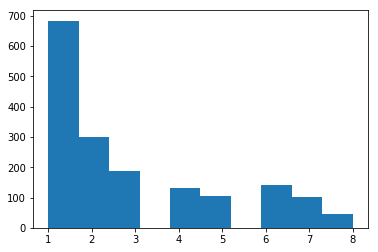

In [416]:
plt.hist(x=visits_distribution,normed=False)